In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(color_codes=True)

from support_functions import log_progress

___
# Extract PPI network from STRING-4.0 database

First step is to detemine the string IDs of human genes.

In [119]:
# first map STRING IDs to gene symbols
string_protein_aliases = pd.read_csv('data/9606.protein.aliases.v10.5.txt', sep='\t', header=0)
# find entries that correspond to primary HUGO gene symbol identifiers
HUGO_symbol_entries =np.flatnonzero(np.core.defchararray.find(string_protein_aliases.source.values.astype(str),'HUGO')!=-1)
string_gene_ids = string_protein_aliases.iloc[HUGO_symbol_entries]

In [120]:
# convert to a dictionary for fast lookup
string_gene_ids.columns = ['string_protein_id', 'alias', 'source']
string_gene_id_pairs = string_gene_ids[['string_protein_id', 'alias']].copy()

In [136]:
string_id_dict = {}
pair_dict = string_gene_id_pairs.set_index('string_protein_id').T.to_dict()
for key in pair_dict:
    gene_name = pair_dict[key]['alias']
    string_id_dict[key] = gene_name

/Users/Nico/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:891: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  "columns will be omitted.", UserWarning)


 Second step is to extract interactions involving these genes.

In [108]:
string_protein_links = pd.read_csv('data/9606.protein.links.v10.5.txt', sep=' ', header=0)
print('Number of unique links (interactions) in STRING database: ', string_protein_links.shape[0])

Number of unique links (interactions) in STRING database:  11353056


In [140]:
# arrays to construct final dataframe
gene_1_ = []
gene_2_ = []
score_ = []

# extract links between human protein genes
for index, row in log_progress(string_protein_links.iterrows(), every=100):
    id_1 = row['protein1']
    id_2 = row['protein2']
    
    # verify both interaction partners are human genes
    if ((id_1 in string_id_dict) & 
        (id_2 in string_id_dict)):
        
        # translate IDs to gene symbols
        gene_1 = string_id_dict[id_1]
        gene_2 = string_id_dict[id_2]
        score = row['combined_score']
        
        gene_1_.append(gene_1)
        gene_2_.append(gene_2)
        score_.append(score)

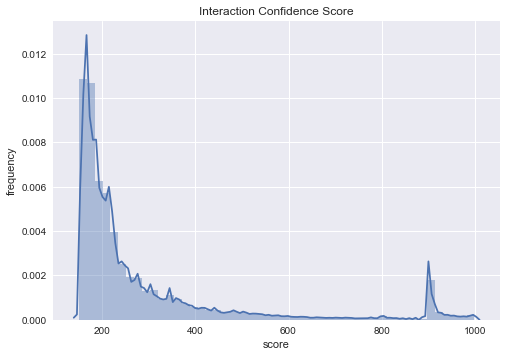

In [146]:
string_gene_interactions = pd.DataFrame({'gene_1': gene_1_, 'gene_2': gene_2_, 'score': score_})
sns.distplot(string_gene_interactions.score)
plt.title('Interaction Confidence Score')
plt.ylabel('frequency')
plt.show()

According to STRING, high-confidence interactions are ones with score 700 or greater.

In [148]:
string_gene_interactions_700 = string_gene_interactions.query('score > 700').copy()
print('Number of high-confidence interactions: ', len(string_gene_interactions_700))

Number of high-confidence interactions:  710638


In [149]:
# save to file
string_gene_interactions_700.to_csv('checkpoint_files/string_gene_interactions_700.csv')